z:\OneDrive\OneDrive - UNIVERSIDAD DE GRANADA\S.Telecom\HUB\SCA\scalib.py:824: SyntaxWarning: invalid escape sequence '\p'
  ax2.set(xlabel='Frecuencia normalizada ($x \pi$ rad/muestra)')
z:\OneDrive\OneDrive - UNIVERSIDAD DE GRANADA\S.Telecom\HUB\SCA\scalib.py:850: SyntaxWarning: invalid escape sequence '\p'
  ax.set(xlabel='Frecuencia normalizada ($x \pi$ rad/muestra)')


Niveles cuantificador Normal: [-0.208 -0.129 -0.071 -0.022  0.024  0.073  0.131  0.211]
Niveles cuantificador Rayleigh: [0.325 0.664 0.974 1.284 1.611 1.976 2.424 3.089]
Niveles cuantificador Uniforme: [-0.875 -0.625 -0.372 -0.122  0.127  0.376  0.627  0.877]
Separación entre niveles (Normal): [0.08  0.058 0.048 0.046 0.049 0.058 0.081]
Separación entre niveles (Rayleigh): [0.339 0.31  0.31  0.328 0.364 0.448 0.666]
Separación entre niveles (Uniforme): [0.25  0.253 0.251 0.249 0.249 0.251 0.249]


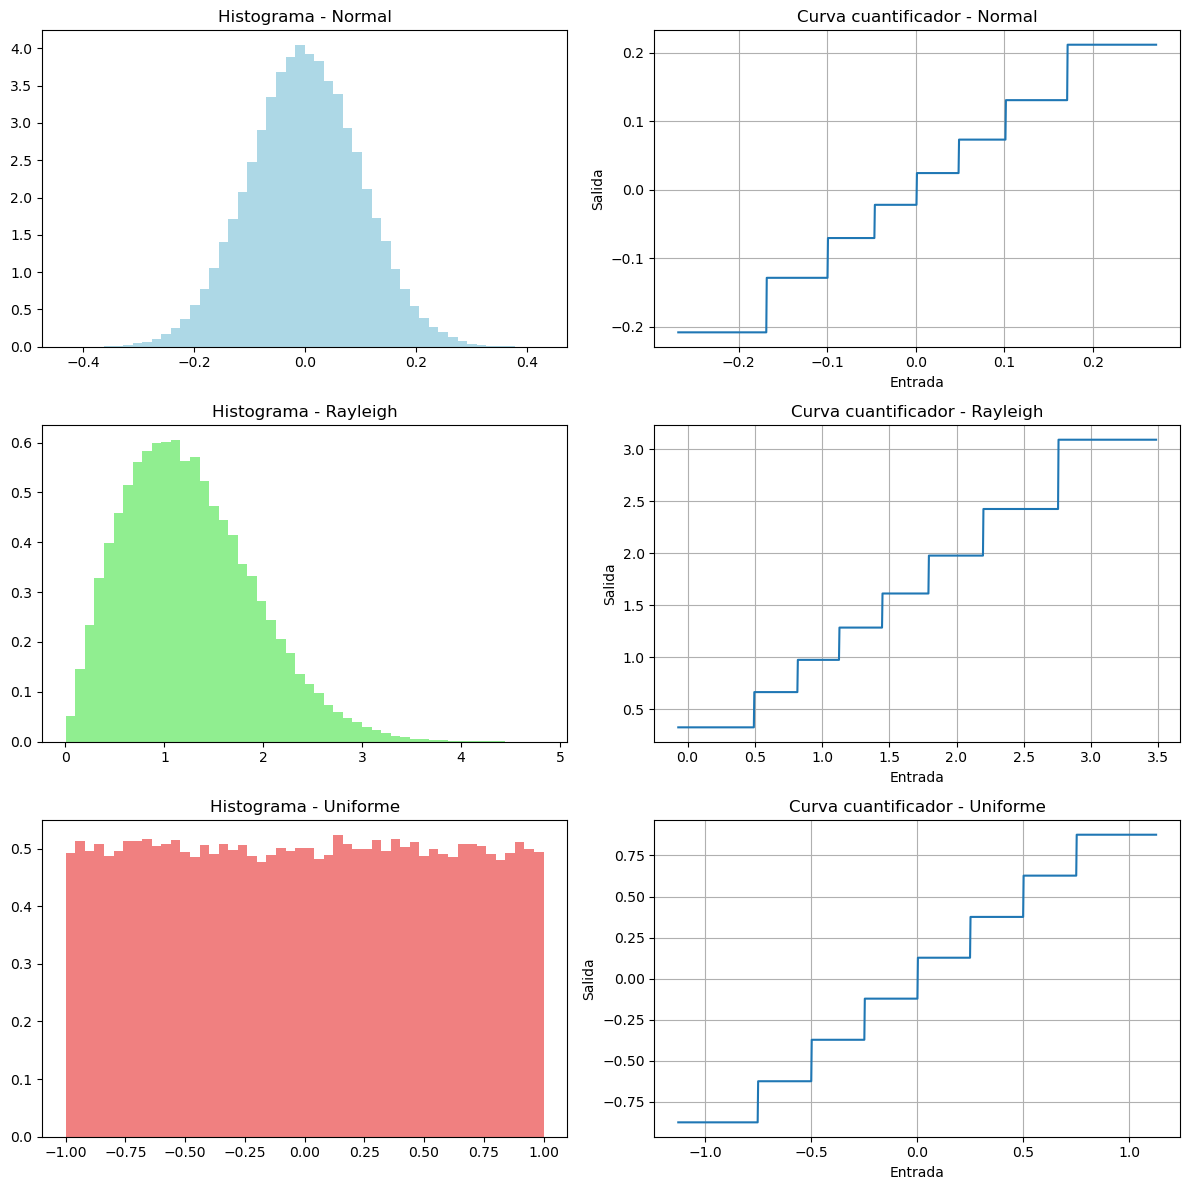

Niveles cuantificador UniformSQ: [-0.875 -0.625 -0.375 -0.125  0.125  0.375  0.625  0.875]


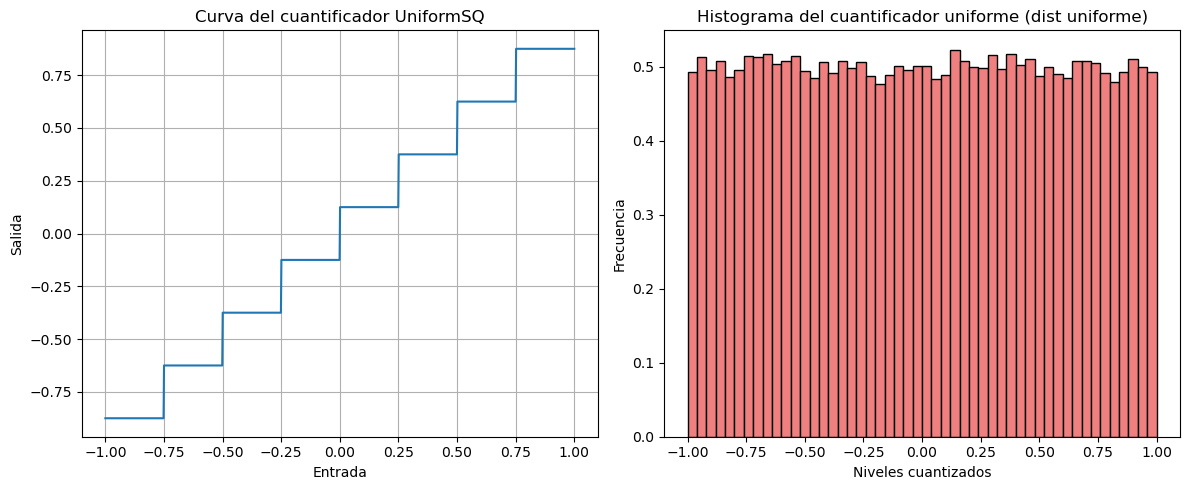

Tasa de bits: 4 bits/muestra
  - SNR (cuantificador óptimo): 17.25 dB
  - SNR (cuantificador uniforme): 6.69 dB
-------------------------------
Tasa de bits: 6 bits/muestra
  - SNR (cuantificador óptimo): 28.61 dB
  - SNR (cuantificador uniforme): 21.76 dB
-------------------------------


In [ ]:
# %%
# librerias
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wf
from skimage import io, color
from scalib import OptimalSQ
from scalib import UniformSQ
from scalib import OptimalVQ
from scalib import signalRange
from scalib import snr
from scalib import partitionImage, composeImage
import sounddevice as sd

# %% Ejercicio 1: Implementacion del algoritmo de Lloyd-Max y de Linde-Buzo-Gray

def lloyd(C, training, maxD, maxIter):
    """
    Algoritmo de Lloyd-Max para la cuantificación de señales.
    """
    D_rel = np.inf  # Inicializamos el error relativo
    iteracion = 0

    while D_rel > maxD and iteracion < maxIter:
        # Paso 1: Condicion del vecino más próximo

        R = np.zeros(len(training))  # Matriz de distancias
        for i, x in enumerate(training):
            distances = np.linalg.norm(C - x, axis=1)
            k = np.argmin(
                distances
            )  # Índice del nivel más cercano (el vecino mas proximo para cada x)
            R[i] = k  # Asignamos el índice del nivel más cercano

        # Paso 2: Condición de centroide (media de los valores de entrenamiento
        # tales que tienen el mismo nivel de cuantificación)
        C_temp = np.copy(C)  # Copia de los niveles de cuantificación
        for k in range(len(C)):
            region = training[R == k]
            if len(region) > 0:
                C_temp[k] = np.mean(
                    region
                )  # Actualizamos el nivel como la media de la región
            else:
                C_temp[k] = C[k]  # Si no hay datos, mantenemos el nivel anterior

        D_rel = np.max(np.linalg.norm(C_temp - C, axis=1))  # Error relativo
        C = C_temp

        iteracion += 1

    return C


def lbg(b, training, maxD=1e-3, maxIter=1000, delta=0.001):
    """
    Algoritmo de Linde-Buzo-Gray para la cuantificación de señales.
    """
    C = np.array([np.mean(training, axis=0)])
    while len(C) < (2**b):
        C = np.concatenate((C * (1 - delta), C * (1 + delta)), axis=0)
        C = lloyd(C, training, maxD, maxIter)

    return C


# %%
"""
Ejercicio 2
Construya tres cuantificadores escalares óptimos con una tasa de 3 bits/muestra. Para cada uno
use un conjunto de entrenamiento formado por 100000 muestras aleatorias con las siguientes
distribuciones de probabilidad:

- Normal de media 0 y desviación típica 0.1.
- Rayleigh con parámetro sigma = 1.
- Uniforme entre -1 y 1. 

En cada caso, analice la separación entre niveles de cuantificación, la forma del cuantificador
(representación de entradas frente a salidas) respecto a la distribución de probabilidad de los
datos. Use lo siguiente:

- Las funciones normal, rayleigh y uniform de numpy.random para generar las muestras.
- El atributo C de los cuantificadores construidos con las clases de scalib, que almacena el
  conjunto de niveles de cuantificación.
- La función hist de numpy para construir el histograma.
- La función diff de numpy para calcular la distancia entre niveles.

Por último, compare el cuantificador construido con la distribución uniforme con un cuantificador
construido con la clase UniformSQ.
"""
bits = 3
num_muestras = 100000

# Generar conjuntos de entrenamiento para cada distribución
entrenamiento_normal = np.random.normal(0, 0.1, num_muestras)
entrenamiento_rayleigh = np.random.rayleigh(1, num_muestras)
entrenamiento_uniforme = np.random.uniform(-1, 1, num_muestras)

# Construir cuantificadores escalares óptimos usando OptimalSQ con nuestro algoritmo lbg
cuantificador_normal = OptimalSQ(bits, entrenamiento_normal, algorithm=lbg)
cuantificador_rayleigh = OptimalSQ(bits, entrenamiento_rayleigh, algorithm=lbg)
cuantificador_uniforme = OptimalSQ(bits, entrenamiento_uniforme, algorithm=lbg)

# Redondear a 3 decimales antes de imprimir
print("Niveles cuantificador Normal:", np.round(cuantificador_normal.C, 3))
print("Niveles cuantificador Rayleigh:", np.round(cuantificador_rayleigh.C, 3))
print("Niveles cuantificador Uniforme:", np.round(cuantificador_uniforme.C, 3))

# Calcular y redondear la separación entre niveles
separacion_normal = np.round(np.diff(cuantificador_normal.C), 3)
separacion_rayleigh = np.round(np.diff(cuantificador_rayleigh.C), 3)
separacion_uniforme = np.round(np.diff(cuantificador_uniforme.C), 3)

print("Separación entre niveles (Normal):", separacion_normal)
print("Separación entre niveles (Rayleigh):", separacion_rayleigh)
print("Separación entre niveles (Uniforme):", separacion_uniforme)

# Graficar histogramas de las muestras y la curva del cuantificador (entrada vs salida)
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

# Para la distribución Normal
axs[0, 0].hist(entrenamiento_normal, bins=50, density=True, color="lightblue")
axs[0, 0].set_title("Histograma - Normal")
cuantificador_normal.plot(ax=axs[0, 1])
axs[0, 1].set_title("Curva cuantificador - Normal")

# Para la distribución Rayleigh
axs[1, 0].hist(entrenamiento_rayleigh, bins=50, density=True, color="lightgreen")
axs[1, 0].set_title("Histograma - Rayleigh")
cuantificador_rayleigh.plot(ax=axs[1, 1])
axs[1, 1].set_title("Curva cuantificador - Rayleigh")

# Para la distribución Uniforme
axs[2, 0].hist(entrenamiento_uniforme, bins=50, density=True, color="lightcoral")
axs[2, 0].set_title("Histograma - Uniforme")
cuantificador_uniforme.plot(ax=axs[2, 1])
axs[2, 1].set_title("Curva cuantificador - Uniforme")

plt.tight_layout()
plt.show()

# Comparación: cuantificador construido con la clase UniformSQ para distribución uniforme
rango_entrada = (-1, 1)
cuantificador_uniforme_uniforme = UniformSQ(bits, rango_entrada, qtype="midrise")
print("Niveles cuantificador UniformSQ:", cuantificador_uniforme_uniforme.C)

# Crear un subplot para la curva del cuantificador y el histograma de los datos cuantizados
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Subplot 1: Curva del cuantificador
cuantificador_uniforme_uniforme.plot(ax=axs[0])
axs[0].set_title("Curva del cuantificador UniformSQ")

# Subplot 2: Histograma de los datos cuantizados (50 bins)
axs[1].hist(
    entrenamiento_uniforme, bins=50, color="lightcoral", edgecolor="black", density=True
)
axs[1].set_title("Histograma del cuantificador uniforme (dist uniforme)")
axs[1].set_xlabel("Niveles cuantizados")
axs[1].set_ylabel("Frecuencia")

plt.tight_layout()
plt.show()

# %%
"""
Ejercicio 3

Construya un cuantificador escalar óptimo para señales de voz con una tasa de 4 bits/muestra.
Use las señales almacenadas en ciudad.wav, mar.wav, rio.wav y santander.wav concatenadas
como conjunto de entrenamiento.

Luego, cuantifique la señal en altura.wav. Reproduzca la señal cuantificada y calcule su SNR.
Repita el análisis para cuantificadores de 6 y 8 bits/muestra.

Compare los resultados (SNR y calidad percibida) con los de cuantificadores uniformes con la
misma tasa de bits.
"""


# Función auxiliar para extraer una única pista en caso de que la señal sea estéreo
def convertirAMono(senal):
    if senal.ndim > 1:
        return senal[:, 0]
    return senal
#Se pasa a mono porque el algoritmo de cuantificación (OptimalSQ o UniformSQ) 
# está preparado para trabajar con vectores 1D.

# 1. Leer y concatenar las señales de entrenamiento (usando rutas relativas)
archivos_entrenamiento = [
    "Datos/ciudad.wav",
    "Datos/mar.wav",
    "Datos/rio.wav",
    "Datos/santander.wav",
]

senales_entrenamiento = []
for archivo in archivos_entrenamiento:
    tasa, datos = wf.read(archivo)
    datos = convertirAMono(datos).astype(float)
    senales_entrenamiento.append(datos)
# Concatenar las señales de entrenamiento
datos_entrenamiento = np.concatenate(senales_entrenamiento)

# 2. Leer la señal de prueba (usando la ruta relativa)
tasa_prueba, senal_prueba = wf.read("Datos/altura.wav")
senal_prueba = convertirAMono(senal_prueba).astype(float)

# 3. Procesar para cada tasa de bits
tasas_bits = [4, 6, 8]

# Diccionarios para almacenar resultados
cuantizados_optimos = {}
cuantizados_uniformes = {}
snr_optimo = {}
snr_uniforme = {}

# Para determinar el rango de entrada para el cuantificador uniforme, se usa el entrenamiento
rango_entrada = (np.min(datos_entrenamiento), np.max(datos_entrenamiento))

for bits in tasas_bits:
    # Construir cuantificador óptimo con algoritmo lbg (asegúrate de tener definida la función lbg)
    cuantificador_optimo = OptimalSQ(bits, datos_entrenamiento, algorithm=lbg)
    cuantizado_optimo = cuantificador_optimo.quantize(senal_prueba)
    cuantizados_optimos[bits] = cuantizado_optimo
    snr_optimo[bits] = snr(senal_prueba, cuantizado_optimo)

    # Construir cuantificador uniforme
    cuantificador_uniforme = UniformSQ(bits, rango_entrada, qtype="midrise")
    cuantizado_uniforme = cuantificador_uniforme.quantize(senal_prueba)
    cuantizados_uniformes[bits] = cuantizado_uniforme
    snr_uniforme[bits] = snr(senal_prueba, cuantizado_uniforme)

    print(f"Tasa de bits: {bits} bits/muestra")
    print(f"  - SNR (cuantificador óptimo): {snr_optimo[bits]:.2f} dB")
    print(f"  - SNR (cuantificador uniforme): {snr_uniforme[bits]:.2f} dB")
    print("-------------------------------")

# Reproducción de la señal
print("Reproduciendo señal original (altura.wav):")
sd.play(senal_prueba, samplerate=tasa_prueba)
sd.wait()

print("Reproduciendo señal cuantificada (cuantificador óptimo, 4 bits):")
sd.play(cuantizados_optimos[4], samplerate=tasa_prueba)
sd.wait()

print("Reproduciendo señal cuantificada (cuantificador uniforme, 4 bits):")
sd.play(cuantizados_uniformes[4], samplerate=tasa_prueba)
sd.wait()

# %%
"""
Ejercicio 4

Construya un cuantificador escalar óptimo para imágenes con una tasa de 4 bits/muestra. Use
las imágenes caravana.png, maiz.png, fresas.png y oficina.png concatenadas como conjunto
de entrenamiento.

A continuación, cuantifique lena.png. Represente la imagen cuantificada y calcule su SNR.
Repita el análisis para una tasa de 6 bits/muestra.

Compare los resultados en términos de SNR y calidad percibida con los obtenidos con cuantificadores
uniformes con la misma tasa de bits.
"""
# 1. Leer y concatenar las imágenes de entrenamiento desde la carpeta "Datos"
archivos_entrenamiento = [
    "Datos/caravana.png",
    "Datos/maiz.png",
    "Datos/fresas.png",
    "Datos/oficina.png",
]
imagenes_entrenamiento = []

for archivo in archivos_entrenamiento:
    imagen = io.imread(archivo)
    # Convertir a escala de grises si es una imagen en color
    if imagen.ndim == 3:
        imagen = color.rgb2gray(imagen)
    # Convertir a float (valores entre 0 y 1)
    imagen = imagen.astype(float)
    imagenes_entrenamiento.append(imagen)

# Concatenar todas las imágenes de entrenamiento en un único vector (aplanando cada imagen)
datos_entrenamiento = np.concatenate(
    [imagen.flatten() for imagen in imagenes_entrenamiento]
)

# 2. Leer la imagen de prueba (lena.png) desde la carpeta "Datos"
imagen_prueba = io.imread("Datos/lena.png")
if imagen_prueba.ndim == 3:
    imagen_prueba = color.rgb2gray(imagen_prueba)
imagen_prueba = imagen_prueba.astype(float)

# 3. Construir cuantificadores para diferentes tasas de bits (4 y 6 bits/muestra)
tasas_bits = [4, 6]

resultados_optimos = {}  # Imágenes cuantificadas con OptimalSQ
resultados_uniformes = {}  # Imágenes cuantificadas con UniformSQ
snr_optimo = {}  # SNR para cuantificador óptimo
snr_uniforme = {}  # SNR para cuantificador uniforme

# Determinar el rango de entrada a partir del conjunto de entrenamiento
rango_entrada = (np.min(datos_entrenamiento), np.max(datos_entrenamiento))

for bits in tasas_bits:
    # Cuantificador óptimo con el algoritmo lbg
    cuantificador_optimo = OptimalSQ(bits, datos_entrenamiento, algorithm=lbg)
    cuantizado_optimo = cuantificador_optimo.quantize(imagen_prueba)
    resultados_optimos[bits] = cuantizado_optimo
    snr_optimo[bits] = snr(imagen_prueba, cuantizado_optimo)

    # Cuantificador uniforme
    cuantificador_uniforme = UniformSQ(bits, rango_entrada, qtype="midrise")
    cuantizado_uniforme = cuantificador_uniforme.quantize(imagen_prueba)
    resultados_uniformes[bits] = cuantizado_uniforme
    snr_uniforme[bits] = snr(imagen_prueba, cuantizado_uniforme)

    print(f"Tasa de bits: {bits} bits/muestra")
    print(f"  - SNR (cuantificador óptimo): {snr_optimo[bits]:.2f} dB")
    print(f"  - SNR (cuantificador uniforme): {snr_uniforme[bits]:.2f} dB")
    print("-------------------------------")

# 4. Visualización de resultados
fig, ejes = plt.subplots(len(tasas_bits), 2, figsize=(10, 5 * len(tasas_bits)))

for i, bits in enumerate(tasas_bits):
    # Imagen cuantificada con OptimalSQ
    ejes[i, 0].imshow(resultados_optimos[bits], cmap="gray")
    ejes[i, 0].set_title(f"OptimalSQ - {bits} bits\nSNR: {snr_optimo[bits]:.2f} dB")
    ejes[i, 0].axis("off")

    # Imagen cuantificada con UniformSQ
    ejes[i, 1].imshow(resultados_uniformes[bits], cmap="gray")
    ejes[i, 1].set_title(f"UniformSQ - {bits} bits\nSNR: {snr_uniforme[bits]:.2f} dB")
    ejes[i, 1].axis("off")

plt.tight_layout()
plt.show()
